# Detecting snow using Sentinel-2

In this trial notebook the Sentinel-2 data sets are explored using popular remote sensing composites: the true color and the false color IR RGB stacks. Composites are applied to the Sierra Nevada area showing growing snow coverage during winter. Raster data sets are read and stacked together along the _band_ dimension, then images are visualised. Also, the NDSI index is computed to better enhance differences between the images.

In [1]:
import os, sys
sys.path.append(os.path.join(os.path.expanduser("~"),"CLEOPE/Trials/modules"))
import data_processing_S2_affine as dp

You can choose to work with local files or using the Advanced API. Functions in this tutorial can manage both choices independently and automatically, but only if product of interest are provided as an input list. <br>
### Using the Advanced API (ENS)
In this case your list must contain the position of products in the remote file system. Note that this list is automatically provided using the `SEARCH.ipynb` trial notebook, aimed at facilitating the data access via ENS. Products are found via ENS at their pseudopath, accessed and processed in situ, without any local download. <br>
### Using OData API
Alternatively you can load a custom list containing the products downloaded in the `local_files` folder. To do that, you can use the `download` function provided in the `qm` module, which will download and save items via your own Jupyter Notebook using OData protocol. Follow the example provided below or check out `DISCOVER_ONDA.ipynb`. <br>
👇 To download a product of interest run the cell below and find out the item in the 📁`local_files` folder placed in your root workspace. The 📄`list_local.txt` file will be created and updated in this working directory with the new downloaded item authomatically.

In [2]:
fsnow = dp.product("tiles_T30SVG.txt") # load your custom product list

## Sentinel-2 bands at your disposal

|MSI band|Descriptor|Central wavelength|Resolution|
|--------|----------|------------------|----------|
|Band 2|B|490 nm|10m|
|Band 3|G|560 nm|10m|
|Band 4|R|665 nm|10m|
|Band 8|NIR|833 nm|10m|
|Band 5|RedEdge 1|705|20m|
|Band 6|RedEdge 2|740|20m|
|Band 7|RedEdge 3|783|20m|
|Band 8A|Narrow NIR|865|20m|
|Band 9| Water Vapor|945|60m|
|Band 10|SWIR Cirrus|1373|60m|
|Band 11|SWIR 1|1610|20m|
|Band 12|SWIR 2|2190|20m|

⚠️ Be careful that color composition and visualisation are a memory consuming processing tasks. Check out RAM information displayed in your IDLE.

### The true color RGB stack

The combination (R,G,B) = (B04,B03,B02) is the popular true color RGB stack. You can apply this composition to your own dataset using the `rgb_bands` function provided in the `data_processing_S2_affine` module.

### A false color IR RGB stack

The combination (R,G,B) = (B12,B11,B05) provides a natural like rendition while also penetrating atmospheric particles, smoke and haze. Vegetation appears dark and lightgreen during the growing season. The almost complete absorption of Mid IR bands in water, ice and snow causes s now and ice to appear as dark blue and water is black or dark blue. You can apply this composition to your own dataset using the `falseir_rgb_bands` function provided in the `data_processing_S2_affine` module.

### Affine reprojection of geo-coordinates

Sentinel-2 `.jp2` data are already geo-referenced but projection is not suitable for a (_lat_,_lon_) clip as it is. The `reproject` function provides the reprojection over bands specified as input argument. You can also call the `clip` function providing the input reprojected dataset and (_xmin_,_xmax_,_ymin_,_ymax_) boundaries to obtain a subset of the image (this will speed-up computations).

In [3]:
re_rgb = []; re_falsergb = []
for file in fsnow:
    re_rgb.append(dp.reproject(bands=dp.rgb_bands(file))) # true color
    re_falsergb.append(dp.reproject(bands=dp.falseir_rgb_bands(file))) # false color

In [4]:
# take a clip of the tile over coordinates xmin,xmax,ymin,ymax
bounds = (-3.634771,-2.596880,36.929058,37.247289)
cli_rgb = [dp.clip(rb,bounds,plot=False) for rb in re_rgb]
cli_falsergb = [dp.clip(rb,bounds,plot=False) for rb in re_falsergb]

### True and False color RGB stacks
In the example below we visualise the true color RGB (left) and the false color RGB (right) of the same portion of the tile. In the false color image, water bodies and snow can be easily distinguished from clouds.

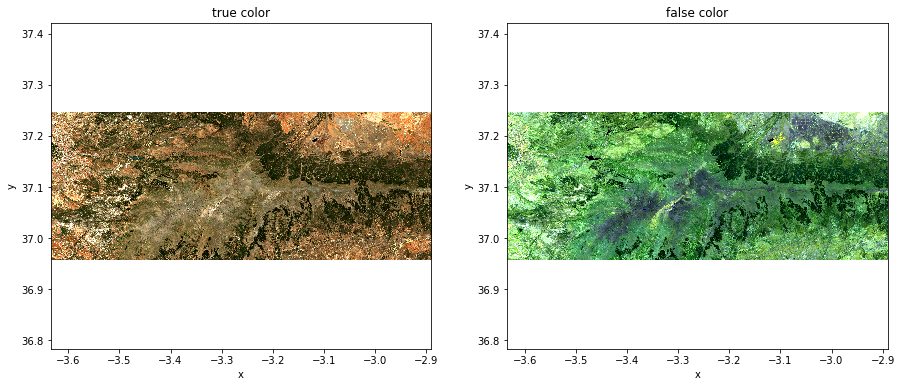

In [5]:
del re_rgb, re_falsergb # remove unused variables (this will improve RAM performances)
import matplotlib.pyplot as plt

titles = ['true color','false color']
fig,ax = plt.subplots(1,2,figsize=(15,6))
cli_rgb[0].plot.imshow(robust=True,ax=ax[0]);
cli_falsergb[0].plot.imshow(robust=True,ax=ax[1]);
for i,axs in enumerate(ax.flat):
    axs.set(title=titles[i])
    axs.axis("equal")

### Snow coverage monitoring via NDSI

Due to the almost complete absorption of solar radiation in the middle IR range by water, snow, and ice, coastlines and water objects are well distinguished. <br>
The _Normalised Difference Snow Index_ is computed as follows, using VIR and SWIR reflectances:

\begin{equation}
\text{NDSI}=\frac{R_{B03}-R_{B11}}{R_{B03}+R_{B11}}
\end{equation}

You can use the function `bands` to search for all bands given the input resolution, of 20 meters in this case; we selected indexes 2 and 7 corresponding to the bands needed for the computation. The function `ratio` will compute the normalised difference given the input _DataArray_. Pay attention to the sort order in which bands are passed to functions.

In [6]:
# print out all bands on screen and pick up idexes you need for the following computation
ndsi_bands = dp.bands(fsnow[0],res='20m')
# print('\n\n'.join(ndsi_bands))

In [7]:
ndsi = []
for f in fsnow:
    ndsi_bands = [dp.bands(f,res='20m')[2],dp.bands(f,res='20m')[7]] # 2,7 indexes for NDSI
    re_ndsi = dp.reproject(bands=ndsi_bands)
    ndsi.append(dp.ratio(re_ndsi))

Values above 0.42 are usually snow, in the image below appear as darker pixels.

In [8]:
import hvplot.xarray

im_ndsi = []
dates = dp.dates(fsnow)
for i,val in enumerate(ndsi):
    im_ndsi.append(val.hvplot.quadmesh(x='x',y='y',cmap='binary',rasterize=True,dynamic=True, aspect='equal',
                                      clabel='NDSI',title=dates[i]))
display(im_ndsi[0])

:DynamicMap   []
   :Image   [x,y]   (value)